# An Analysis of Daily Sales for a Convenience Store Business

10 November, 2023

## Convenience stores see fluctuations in their daily sales. These fluctuations are dependent on multiple variables. The client has requested to identify if and how much of an impact certain variables have on daily sales.

### Our analysis will proceed along the following outline:

    1. We will determine if there is a difference in sale depending on the day of the week.
    2. We will determine if the weather has an impact the given day's sale.
    3. As of September 1st, 2023, New York has increased its tobacco excise taxes. The client would like to know if the tax increase has impacted tobacco sales.

Weather data was acquired from the Weather Underground historical archive. This data was imported using a web-scraping script. The script can be found in the same folder as this notebook on Github.

## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import os
from bs4 import BeautifulSoup
from selenium import webdriver
import time

#modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, ttest_ind_from_stats

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Question 1: Is there a difference in sale depending on the day of the week?

### Reading in and Formatting Sales Data

In [2]:
sales = pd.read_csv('sales_by_day.csv', parse_dates= ['Date'])

In [3]:
#Renaming column for convenience
sales = sales.rename(columns={'Sales $': 'Sales'})

#Converting 'Sales' column from strings to floats so we can perfrom numerical operations on the data
sales['Sales'] = sales['Sales'].str.replace('$', '', regex=True)
sales['Sales'] = sales['Sales'].str.replace(',', '', regex=True)
sales['Sales'] = pd.to_numeric(sales['Sales'])

We will add a column for the days of the week

In [4]:
sales['day_of_week'] = sales['Date'].dt.dayofweek

days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
sales['day_of_week'] = sales['day_of_week'].apply(lambda x: days[x])

We will make sure that we don't have any null values or duplicates in our dataset. We will also start looking at what the data looks like.

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130 entries, 0 to 1129
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1130 non-null   datetime64[ns]
 1   # of Baskets  1130 non-null   int64         
 2   # of Items    1130 non-null   object        
 3   Avg Items     1130 non-null   float64       
 4   Sales         1130 non-null   float64       
 5   Avg Sale      1130 non-null   object        
 6   Scan Rate     1130 non-null   float64       
 7   Scan Sales    1130 non-null   object        
 8   day_of_week   1130 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 79.6+ KB


In [6]:
sales.isnull().sum()

Date            0
# of Baskets    0
# of Items      0
Avg Items       0
Sales           0
Avg Sale        0
Scan Rate       0
Scan Sales      0
day_of_week     0
dtype: int64

In [7]:
sales.nunique()

Date            1130
# of Baskets     151
# of Items       286
Avg Items         16
Sales           1126
Avg Sale         485
Scan Rate        198
Scan Sales      1083
day_of_week        7
dtype: int64

The number of unique dates (1130) matches the number of rows we have in the date column (1130). Since we do not have any null values, we can be confident that there are no duplicates. We also see that our sales values and our date timestamps have been converted into the appropriate types.

## Visualizing the data

Let's start exploring our data!

In [8]:
sales.head()

,Date,# of Baskets,# of Items,Avg Items,Sales,Avg Sale,Scan Rate,Scan Sales,day_of_week
0,2020-10-05,173,321,1.9,1495.16,$8.64,0.0,$0.00,Mon
1,2020-10-06,173,305,1.8,1515.56,$8.76,0.0,$0.00,Tues
2,2020-10-07,150,270,1.8,1228.83,$8.19,0.0,$0.00,Weds
3,2020-10-08,181,341,1.9,1618.21,$8.94,0.0,$0.00,Thurs
4,2020-10-09,188,355,1.9,1664.71,$8.85,0.0,$0.00,Fri


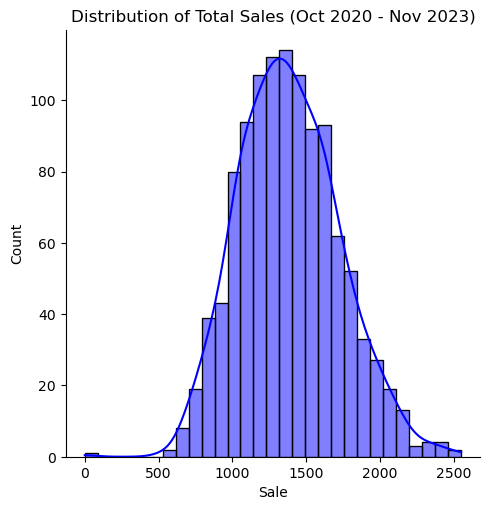

In [9]:
#Distribution plot of our sales data
sns.displot(sales['Sales'], color="blue", kde = True)
plt.title("Distribution of Total Sales (Oct 2020 - Nov 2023)")
plt.xlabel("Sale")
plt.show()

The distribution of daily sales figures is normally distributed. There is no obvious skew. We do have an outlier that I would like to take a look at before we continue our analysis.

In [10]:
sales.loc[sales['Sales'] < 500, :]

,Date,# of Baskets,# of Items,Avg Items,Sales,Avg Sale,Scan Rate,Scan Sales,day_of_week
1129,2023-11-08,0,0,0.0,0.0,$0.00,0.0,$0.00,Weds


The outlier suggests that the sale for November 8th, 2023 was $0. However, I suspect that we are getting a zero value for this data because the data was acquired on this date. The final sales figure were not avaliable for the given date so the POS system stored a zero value in its place. We can omit this value from our analysis.

In [11]:
sales = sales.drop([1129])

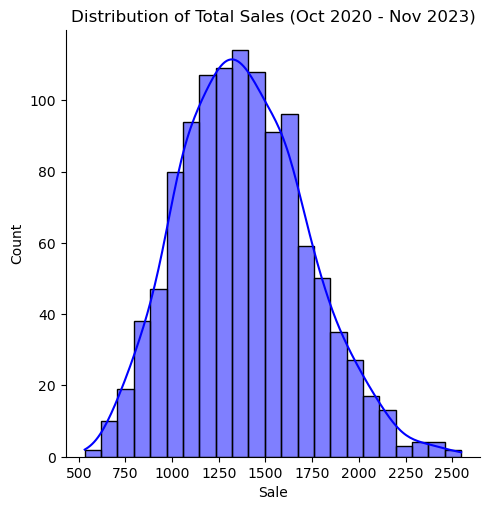

In [12]:
#Adjusted distribution plot of our sales data
sns.displot(sales['Sales'], color="blue", kde = True)
plt.title("Distribution of Total Sales (Oct 2020 - Nov 2023)")
plt.xlabel("Sale")
plt.show()

Looks good!

## Our Analysis

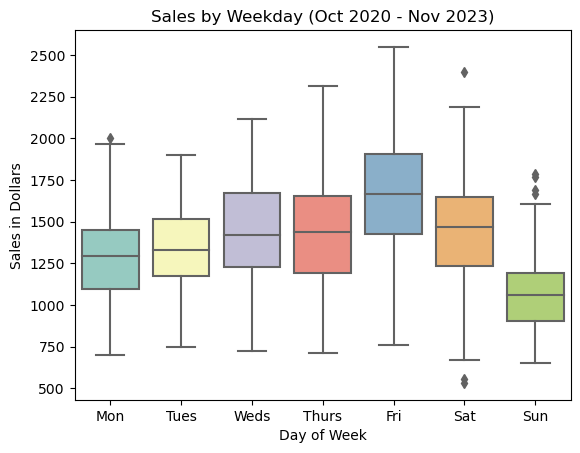

In [13]:
#Box plot of sales figures against day of the week
sns.boxplot(x = 'day_of_week', y = 'Sales', data = sales, palette="Set3")

plt.xlabel('Day of Week')
plt.ylabel('Sales in Dollars')
plt.title('Sales by Weekday (Oct 2020 - Nov 2023)')
plt.show()

Our box plot shows there does seem to a relationship between the day of the week and the sales for that day. While the range for each day varies greatly, on average, Friday has the highest sales figures while Sunday has the lowest sales figures. Our next step is to quantify this difference and check for significance.

In [14]:
#We are finding the mean sales figure for each day of the week
every_day_mean = sales.loc[:, ['Sales']].mean().mean()
mon_sales_mean = sales.loc[sales['day_of_week'] == 'Mon', ['Sales']].mean().mean()
tues_sales_mean = sales.loc[sales['day_of_week'] == 'Tues', ['Sales']].mean().mean()
weds_sales_mean = sales.loc[sales['day_of_week'] == 'Weds', ['Sales']].mean().mean()
thurs_sales_mean = sales.loc[sales['day_of_week'] == 'Thurs', ['Sales']].mean().mean()
fri_sales_mean = sales.loc[sales['day_of_week'] == 'Fri', ['Sales']].mean().mean()
sat_sales_mean = sales.loc[sales['day_of_week'] == 'Sat', ['Sales']].mean().mean()
sun_sales_mean = sales.loc[sales['day_of_week'] == 'Sun', ['Sales']].mean().mean()

#We are storing our means in a dictionary to make it easier to call on in the future
means_by_weekday = {'EveryDay' : every_day_mean,
                    'Mon': mon_sales_mean, 
                    'Tues': tues_sales_mean, 
                    'Weds': weds_sales_mean, 
                    'Thurs': thurs_sales_mean, 
                    'Fri': fri_sales_mean, 
                    'Sat': sat_sales_mean, 
                    'Sun': sun_sales_mean}

means_by_weekday

{'EveryDay': 1384.493436669619,
 'Mon': 1279.6185185185184,
 'Tues': 1334.3632098765434,
 'Weds': 1437.5922360248446,
 'Thurs': 1440.2398136645966,
 'Fri': 1668.6940372670806,
 'Sat': 1458.4883850931678,
 'Sun': 1073.4206211180124}

On average, the sale for Friday is 284.20 dollars (1668.69 - 1384.49) higher than any other given day. On average, the sale for Sunday is 311.07 dollars (1073.42 - 1384.49) is lower than any other given day. We will build a linear regression model to test for the significance of this difference.

In [15]:
#Adding a dummy variable that represents Monday in binary
days = {'Mon': 1,'Tues':0, 'Weds':0, 'Thurs': 0, 'Fri':0 , 'Sat': 0 ,'Sun': 0}
sales['day_of_week_binaryM'] = sales['day_of_week'].apply(lambda x: days[x])

#Adding a dummy variable that represents Tuesday in binary
days = {'Mon': 0,'Tues':1, 'Weds':0, 'Thurs': 0, 'Fri':0 , 'Sat': 0 ,'Sun': 0}
sales['day_of_week_binaryT'] = sales['day_of_week'].apply(lambda x: days[x])

#Adding a dummy variable that represents Wednesday in binary
days = {'Mon': 0,'Tues':0, 'Weds':1, 'Thurs': 0, 'Fri':0 , 'Sat': 0 ,'Sun': 0}
sales['day_of_week_binaryW'] = sales['day_of_week'].apply(lambda x: days[x])

#Adding a dummy variable that represents Thursday in binary
days = {'Mon': 0,'Tues':0, 'Weds':0, 'Thurs': 1, 'Fri':0 , 'Sat': 0 ,'Sun': 0}
sales['day_of_week_binaryTh'] = sales['day_of_week'].apply(lambda x: days[x])

#Adding a dummy variable that represents Friday in binary
days = {'Mon':0,'Tues':0, 'Weds':0, 'Thurs': 0, 'Fri':1 , 'Sat': 0 ,'Sun': 0}
sales['day_of_week_binaryF'] = sales['day_of_week'].apply(lambda x: days[x])

#Adding a dummy variable that represents Saturday in binary
days = {'Mon': 0,'Tues':0, 'Weds':0, 'Thurs': 0, 'Fri': 0 , 'Sat': 1 ,'Sun': 0}
sales['day_of_week_binaryS'] = sales['day_of_week'].apply(lambda x: days[x])

#Adding a dummy variable that represents Sunday in binary
days = {'Mon': 0,'Tues':0, 'Weds':0, 'Thurs': 0, 'Fri':0 , 'Sat': 0 ,'Sun': 1}
sales['day_of_week_binarySu'] = sales['day_of_week'].apply(lambda x: days[x])

Through some trial and error, I found this to be the best model to use:

In [16]:
#define response variable
y = sales['Sales']

#define predictor variables
x = sales[['day_of_week_binaryF', 'day_of_week_binaryS', 'day_of_week_binarySu', 'day_of_week_binaryTh', 'day_of_week_binaryW']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     75.62
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           2.18e-68
Time:                        21:25:49   Log-Likelihood:                -8010.2
No. Observations:                1129   AIC:                         1.603e+04
Df Residuals:                    1123   BIC:                         1.606e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1306.9909 

## Question 1 Results: There is a difference is sales depending on the day of the week!

Our model shows that there is a statistically significant relationship between certain days of the week and sales value (all p-values < .05). Monday and Tuesday did not have statistically significant p-values and are excluded from this model. The R-squared value states that 25.2% of the variance in our sales values can be explained by the variance in the day of the week. Our model shows that Friday has the largest increase on sales (coef = 361.70 dollars) while Sunday has the largest decrease in sales (coef = -233.57 dollars).

## Question 2: Does weather have an impact on sales?

### Question 2a: Does temperature have an impact on sales?

## Reading in and formatting the data

Our weather data was web scraped from the Weather Underground historical archive.

In [17]:
weather = pd.read_csv('/Users/haiderali/Documents/weather_data-10994.csv', parse_dates= ['date'])

In [18]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130 entries, 0 to 1129
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1130 non-null   datetime64[ns]
 1   actual_high_temp      1117 non-null   float64       
 2   histavg_high_temp     1117 non-null   float64       
 3   record_high_temp      1117 non-null   float64       
 4   actual_low_temp       1117 non-null   float64       
 5   histavg_low_temp      1117 non-null   float64       
 6   record_low_temp       1117 non-null   object        
 7   actual_avg_temp       1117 non-null   float64       
 8   histavg_avg_temp      1117 non-null   float64       
 9   record_avg_temp       1117 non-null   object        
 10  actual_precip         1117 non-null   float64       
 11  histavg_precip        1117 non-null   object        
 12  record_precipitation  1117 non-null   object        
dtypes: datetime64[ns](

In [19]:
weather.nunique()

date                    1129
actual_high_temp          77
histavg_high_temp        272
record_high_temp          47
actual_low_temp           78
histavg_low_temp         266
record_low_temp           69
actual_avg_temp          958
histavg_avg_temp         268
record_avg_temp            1
actual_precip             97
histavg_precip             1
record_precipitation       1
dtype: int64

Looking at our data, we see that certain observations have null values. There are 13 certain such observations (1130 -1117). We also have 1 duplicate observation (1130 - 1129). We will try to isolate and correct these observations.

In [20]:
#Find the null observations
nan_indices = weather.isna()

null_indexes = nan_indices.loc[nan_indices['actual_high_temp'] == True, :].index

#Isolate and save the null observations
list_of_null_dates = []

for index in null_indexes:
     
    null_date = weather.iloc[index][0]
    
    null_year = null_date.year
    null_month = null_date.month
    null_day = null_date.day
    
    full_date = (index, (null_year, null_month, null_day))
    
    list_of_null_dates.append(full_date)

In [21]:
list_of_null_dates

[(23, (2020, 10, 28)),
 (35, (2020, 11, 8)),
 (166, (2021, 3, 19)),
 (414, (2021, 11, 22)),
 (550, (2022, 4, 7)),
 (580, (2022, 5, 7)),
 (590, (2022, 5, 17)),
 (732, (2022, 10, 6)),
 (754, (2022, 10, 28)),
 (944, (2023, 5, 6)),
 (959, (2023, 5, 21)),
 (1068, (2023, 9, 7)),
 (1097, (2023, 10, 6))]

Since we have the dates, we can correct our data. Since there are only 13 null values, it would be quicker and easier to manually enter these rather than re-run our web-scraping script. Also, while looking at the raw data, I saw that 2020-10-28 at index 23 was the duplicate.

In [22]:
weather.at[166, 'actual_avg_temp'] = 34.29
weather.at[166, 'actual_precip'] = 0

weather.at[414, 'actual_avg_temp'] = 44.17
weather.at[414, 'actual_precip'] = .04

weather.at[550, 'actual_avg_temp'] = 46.37
weather.at[550, 'actual_precip'] = .06

weather.at[580, 'actual_avg_temp'] = 48.56
weather.at[580, 'actual_precip'] = .77

weather.at[590, 'actual_avg_temp'] = 63.65
weather.at[590, 'actual_precip'] = .12

weather.at[732, 'actual_avg_temp'] = 61.84
weather.at[732, 'actual_precip'] = 0

weather.at[754, 'actual_avg_temp'] = 47.46
weather.at[754, 'actual_precip'] = 0

weather.at[944, 'actual_avg_temp'] = 57.92
weather.at[944, 'actual_precip'] = 0

weather.at[959, 'actual_avg_temp'] = 61.52
weather.at[959, 'actual_precip'] = 1.48

weather.at[1068, 'actual_avg_temp'] = 80.07
weather.at[1068, 'actual_precip'] = 0

weather.at[1097, 'actual_avg_temp'] = 65.84
weather.at[1097, 'actual_precip'] = 0

weather = weather.drop([23, 35])

We've added our missing data and dropped the duplicate. I could not find data for 2020-11-8 so we will drop that observation. We also only need the average temperate and the precipitation data.

## Visualizing the data

Let's explore this data

In [23]:
daily_temp = weather.loc[:, ['date', 'actual_avg_temp']]

In [24]:
sales_w_temp = pd.merge(sales, daily_temp, how='outer', left_on='Date', right_on= 'date')

In [25]:
sales_w_temp.head()

,Date,# of Baskets,# of Items,Avg Items,Sales,Avg Sale,Scan Rate,Scan Sales,day_of_week,day_of_week_binaryM,day_of_week_binaryT,day_of_week_binaryW,day_of_week_binaryTh,day_of_week_binaryF,day_of_week_binaryS,day_of_week_binarySu,date,actual_avg_temp
0,2020-10-05,173,321,1.9,1495.16,$8.64,0.0,$0.00,Mon,1,0,0,0,0,0,0,2020-10-05,54.00
1,2020-10-06,173,305,1.8,1515.56,$8.76,0.0,$0.00,Tues,0,1,0,0,0,0,0,2020-10-06,58.47
2,2020-10-07,150,270,1.8,1228.83,$8.19,0.0,$0.00,Weds,0,0,1,0,0,0,0,2020-10-07,61.92
3,2020-10-08,181,341,1.9,1618.21,$8.94,0.0,$0.00,Thurs,0,0,0,1,0,0,0,2020-10-08,55.38
4,2020-10-09,188,355,1.9,1664.71,$8.85,0.0,$0.00,Fri,0,0,0,0,1,0,0,2020-10-09,52.71


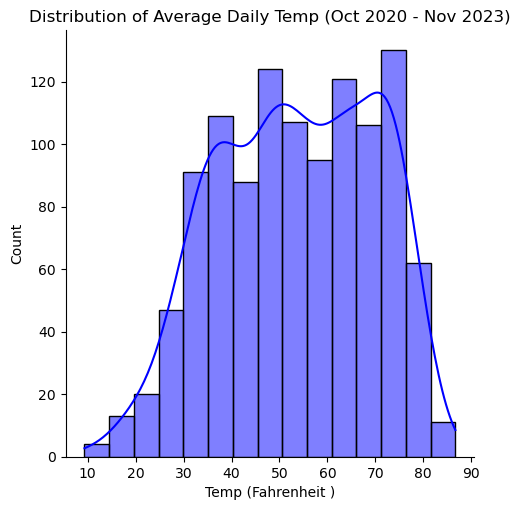

In [26]:
sns.displot(sales_w_temp['actual_avg_temp'], color="blue", kde = True)
plt.title("Distribution of Average Daily Temp (Oct 2020 - Nov 2023)")
plt.xlabel("Temp (Fahrenheit )")
plt.show()

While there is no clear peak, there is no obvious skewness or obvious outlier in temperature data. We also have a high number of observations.

## Our analysis

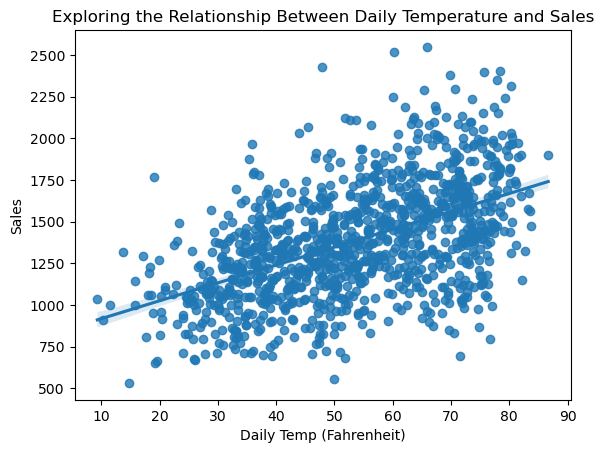

In [27]:
sns.regplot(data=sales_w_temp, x='actual_avg_temp', y = 'Sales')
plt.title('Exploring the Relationship Between Daily Temperature and Sales')
plt.xlabel('Daily Temp (Fahrenheit)')
plt.show()

Our scatterplot indicates that there is a positive relationship between temperature and sales. As temperature increases, our sale increases. We will build a linear regression model to test for significance.

In [28]:
#We don't have data for this point and need to drop it to avoid errors while building our model
sales_w_temp = sales_w_temp.drop([34])

#define response variable
y = sales_w_temp['Sales']

#define predictor variables
x = sales_w_temp['actual_avg_temp']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     406.0
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           2.38e-77
Time:                        21:25:50   Log-Likelihood:                -7993.6
No. Observations:                1128   AIC:                         1.599e+04
Df Residuals:                    1126   BIC:                         1.600e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             810.2505     29.779     

### Question 2a results: Daily temperature does have an effect on sales for that given day.

Our model shows that there is a statistically significant relationship between the average daily temperature and sales (all p-values < .05). There is a positive relationship between daily temperature and sales. According to our model, a 1 degree increase in temperature results in a 10.72 dollar increase in sale (coef = 10.72). The R-squared value states that 26.5% of the variance in our sales values can be explained by the variance daily temperature.

### Question 2b: Does the amount of precipitation have an effect on sale?

### Preparing the data

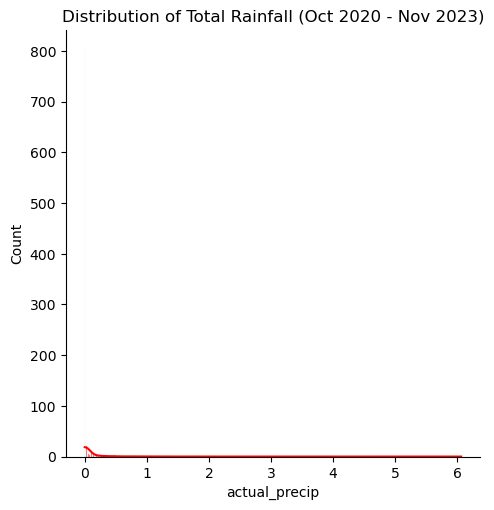

In [29]:
sns.displot(weather['actual_precip'], color="red", kde = True)
plt.title("Distribution of Total Rainfall (Oct 2020 - Nov 2023)")
plt.show()

The precipitation is heavily right skewed. Too many days have a zero value for precipitation. We will still build our linear regression model to check for significance. However, after this test, I would like to modify the question to: If it rains, does the amount of rain effect sale? I will like to exclude all zero precipitation value and perform a log transformation on the values before building a second model. 

In [30]:
weather['log_rain'] = np.log2(weather.loc[weather['actual_precip'] > 0, ['actual_precip']])

In [31]:
daily_precip = weather.loc[:, ['date', 'actual_precip', 'log_rain']]

In [32]:
sales_w_rain = pd.merge(sales, daily_precip, how='outer', left_on='Date', right_on= 'date')

In [33]:
sales_w_rain_true = sales_w_rain.loc[sales_w_rain['actual_precip'] > 0]

In [34]:
sales_w_rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 0 to 1128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1129 non-null   datetime64[ns]
 1   # of Baskets          1129 non-null   int64         
 2   # of Items            1129 non-null   object        
 3   Avg Items             1129 non-null   float64       
 4   Sales                 1129 non-null   float64       
 5   Avg Sale              1129 non-null   object        
 6   Scan Rate             1129 non-null   float64       
 7   Scan Sales            1129 non-null   object        
 8   day_of_week           1129 non-null   object        
 9   day_of_week_binaryM   1129 non-null   int64         
 10  day_of_week_binaryT   1129 non-null   int64         
 11  day_of_week_binaryW   1129 non-null   int64         
 12  day_of_week_binaryTh  1129 non-null   int64         
 13  day_of_week_binary

In [35]:
sales_w_rain_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 7 to 1128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  327 non-null    datetime64[ns]
 1   # of Baskets          327 non-null    int64         
 2   # of Items            327 non-null    object        
 3   Avg Items             327 non-null    float64       
 4   Sales                 327 non-null    float64       
 5   Avg Sale              327 non-null    object        
 6   Scan Rate             327 non-null    float64       
 7   Scan Sales            327 non-null    object        
 8   day_of_week           327 non-null    object        
 9   day_of_week_binaryM   327 non-null    int64         
 10  day_of_week_binaryT   327 non-null    int64         
 11  day_of_week_binaryW   327 non-null    int64         
 12  day_of_week_binaryTh  327 non-null    int64         
 13  day_of_week_binaryF

In [36]:
#We are dropping the one day's observation for which we do not have weather data
sales_w_rain = sales_w_rain.dropna()

Let's look at the distribution of our log2('actual_precip) data. Again, we have excluded all zero values of actual_precip from the data and transformed it hoping that there is a more normal distribution of precipiation values. With this transformation, we are modifying our question from how much does rain impact sales to if it rains, does the amount of rain impact sales.

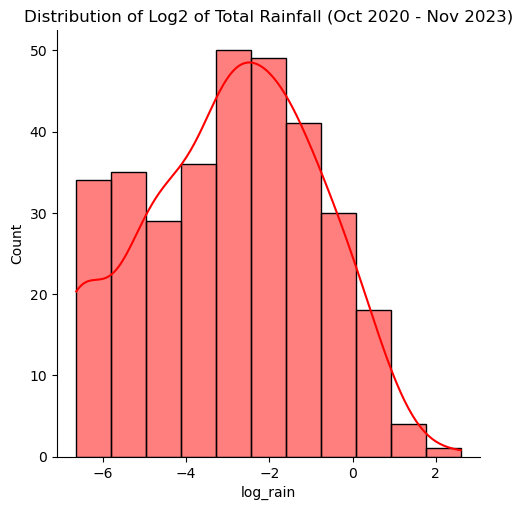

In [37]:
sns.displot(sales_w_rain_true['log_rain'], color="red", kde = True)
plt.title("Distribution of Log2 of Total Rainfall (Oct 2020 - Nov 2023)")
plt.show()

The distribution still seems to have a right skew.

### Our analysis

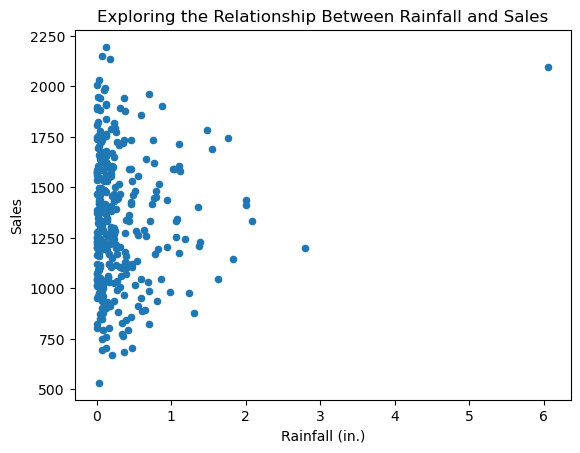

In [38]:
sales_w_rain.plot.scatter(x='actual_precip', y = 'Sales', xlabel = 'Rainfall (in.)')
plt.title('Exploring the Relationship Between Rainfall and Sales')

plt.show()

There does not seem to be any obvious relationship between rainfall and sales according to our scatterplot. Given what we see here, I would not expect to see a high R-squared value if we were to build a linear regression model. I would like to see what a line of best fit would look like here.

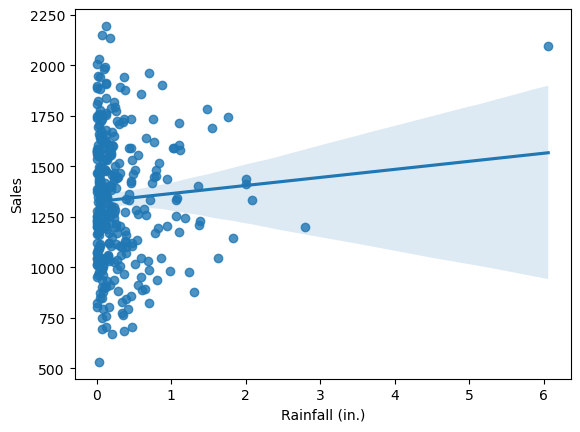

In [39]:
sns.regplot(data=sales_w_rain, x='actual_precip', y = 'Sales')
plt.xlabel('Rainfall (in.)')
plt.show()

While there does seem to a slight positive relationship between rainfall and sales, I believe that the outlier at the x value of 6 inches of rainfall is having an outsized influence on the line of best fit. Running a log transformation will help us deal with this outlier and the effect it is having on our analysis.

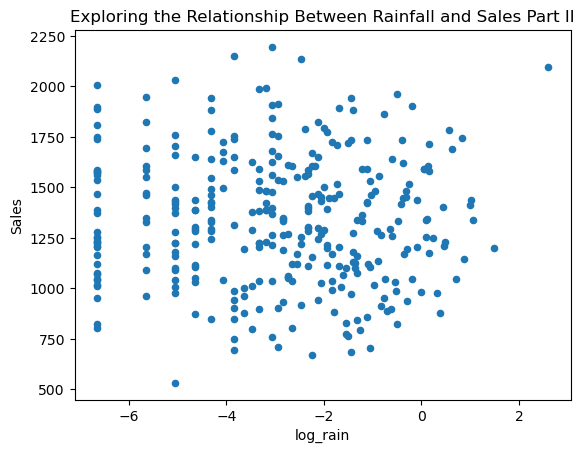

In [40]:
sales_w_rain_true.plot.scatter(x='log_rain', y = 'Sales')
plt.title('Exploring the Relationship Between Rainfall and Sales Part II')

plt.show()

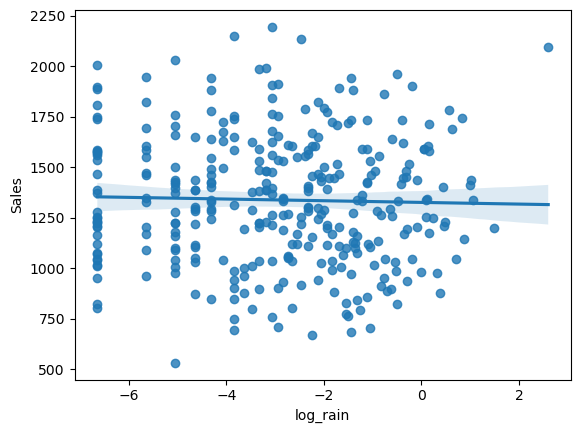

In [41]:
sns.regplot(data=sales_w_rain_true, x='log_rain', y = 'Sales')
plt.show()

Our data is distributed more randomly compared to the untransformed data. However, I still do not see any relationship between rainfall and sales. The line of best fit is mostly flat. Our outlier, while still present in the data we are anaylzing, is no longer having an outsized influence on our analysis. I would expect a low R-squared value.

In [42]:
#define response variable
y = sales_w_rain['Sales']

#define predictor variables
x = sales_w_rain['actual_precip']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.370
Date:                Sat, 18 Nov 2023   Prob (F-statistic):              0.243
Time:                        21:25:51   Log-Likelihood:                -2346.9
No. Observations:                 327   AIC:                             4698.
Df Residuals:                     325   BIC:                             4705.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1325.5042     20.635     64.237

In [43]:
#define response variable
y = sales_w_rain_true['Sales']

#define predictor variables
x = sales_w_rain_true['log_rain']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2410
Date:                Sat, 18 Nov 2023   Prob (F-statistic):              0.624
Time:                        21:25:51   Log-Likelihood:                -2347.5
No. Observations:                 327   AIC:                             4699.
Df Residuals:                     325   BIC:                             4707.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1325.8778     30.603     43.325      0.0

### Question 2b results: Precipitation does not have an effect on sales.

Our linear regression models show that there is no significant relationship between precipitation and sales (p-value > .05). Both models have extremely low R-squared values. Thus, almost none of the variance in sales values can be explained by the variance in precipitation values.

## Did the increase in tobacco sales tax effect tobacco sales?

### Reading in and formatting data

In [44]:
dept_sales = pd.read_csv('deptsales_by_day.csv', parse_dates= ['Date'])

In [45]:
#the # of items is currently a string and needs to be converted to a float
dept_sales['# of Items'] = dept_sales['# of Items'].str.replace(',', '', regex=True)
dept_sales['# of Items'] = pd.to_numeric(dept_sales['# of Items'])

In [46]:
#Isolating the tobacco sales
dept_sales_tobacco = dept_sales.loc[dept_sales['Department'] == 'Tobacco', :]

In [47]:
#Splitting the data into pre-tax and post-tax DataFrames
dept_sales_tobacco_post = dept_sales_tobacco.loc[dept_sales_tobacco['Date'] >= '2023-09-01', :]
dept_sales_tobacco_pre = dept_sales_tobacco.loc[dept_sales_tobacco['Date'] < '2023-09-01', :]

### Visualizing the data

Rather than look at the dollar value of sales, we want to look at the number of cigarette packs that are sold each day. Looking at just the dollar value of sales might lead to a conclusion that cigarette sales have increased because of the increase in the price of cigarettes. Since the increase in price is a result of the increase in taxes, profit per pack is the same. If profit per pack is the same and cigarette sales volume decreases, overall profit (the metric that the client cares about) would be decrease.

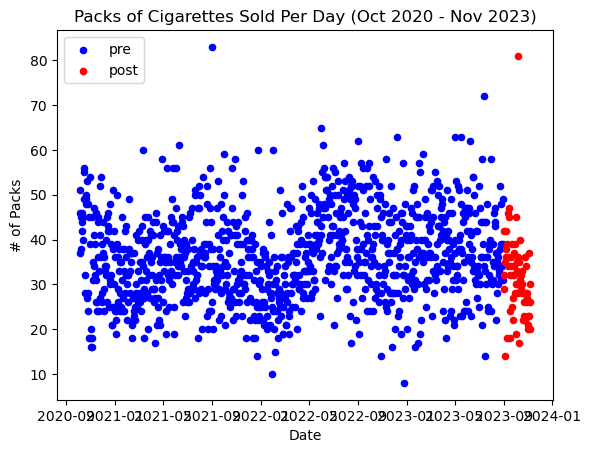

In [48]:
ax = dept_sales_tobacco_pre.plot.scatter(x='Date', y = '# of Items', label = 'pre', color = 'blue')
dept_sales_tobacco_post.plot.scatter(x='Date', y = '# of Items', label = 'post', ax = ax, color = 'red', ylabel = '# of Packs')
plt.title("Packs of Cigarettes Sold Per Day (Oct 2020 - Nov 2023)")
plt.show()

Our scatterplot indicates that post tax increase, fewer cigarette packs have been sold.

We also want to see if the number of tobacco customers has decreased. We want to determine if we lost customers or if the same number of customers are buying fewer cigarettes.

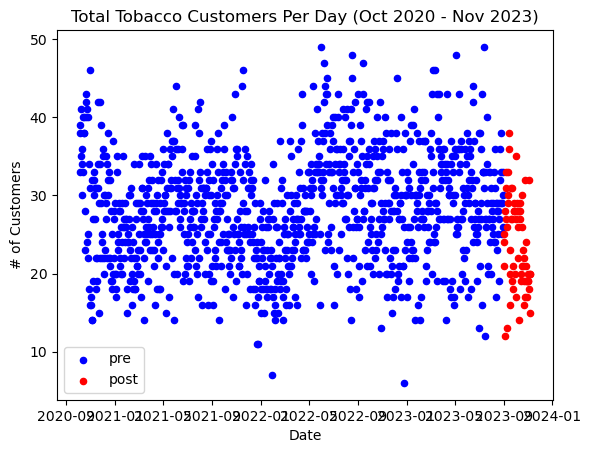

In [49]:
ax = dept_sales_tobacco_pre.plot.scatter(x='Date', y = '# of Baskets', label = 'pre', color = 'blue')
dept_sales_tobacco_post.plot.scatter(x='Date', y = '# of Baskets', label = 'post', ax = ax, color = 'red', ylabel = '# of Customers')
plt.title("Total Tobacco Customers Per Day (Oct 2020 - Nov 2023)")
plt.show()

Our scatterplot indicates that post tax increase, fewer customers are buying cigarettes.

### Our analysis

We will conduct t-tests to see if there is a significant change in tobacco sales after the increase in tobacco excise taxes. Our first test will look for a significant change in total cigarette sales volume.

In [50]:
dept_sales_tobacco_pre['# of Items'].mean(), dept_sales_tobacco_post['# of Items'].mean()

(36.31573986804901, 31.264705882352942)

In [51]:
ttest_ind(dept_sales_tobacco_pre['# of Items'], dept_sales_tobacco_post['# of Items'])

Ttest_indResult(statistic=4.07849623619984, pvalue=4.851545271699038e-05)

Our second test will look for a significant change in the number of tobacco customers per day.

In [52]:
dept_sales_tobacco_pre['# of Baskets'].mean(), dept_sales_tobacco_post['# of Baskets'].mean()

(28.201696512723846, 24.102941176470587)

In [53]:
ttest_ind(dept_sales_tobacco_pre['# of Baskets'], dept_sales_tobacco_post['# of Baskets'])

Ttest_indResult(statistic=4.669804585197894, pvalue=3.3774609256562433e-06)

Our final test will look for a significant change in the number of tobacco customers post-tax increase as compared to the same period in 2022. We want to ensure that any cyclical nature of tobacco sales is not impacting is not impacting our analysis.

In [54]:
dept_sales_last = dept_sales_tobacco_pre.loc[dept_sales_tobacco_pre['Date'] >= '2022-09-01', :]
dept_sales_last = dept_sales_last.loc[dept_sales_last['Date'] <= '2022-11-10', :] 

In [55]:
dept_sales_last['# of Baskets'].mean(), dept_sales_tobacco_post['# of Baskets'].mean()

(30.56338028169014, 24.102941176470587)

In [56]:
ttest_ind(dept_sales_last['# of Baskets'], dept_sales_tobacco_post['# of Baskets'])

Ttest_indResult(statistic=5.790291170054535, pvalue=4.5864459331666646e-08)

## Question 3 results: The increase in tobacco excise taxes had an effect on tobacco sales.

There was a significant decrease in tobacco sales as a result of the increase in tobacco excise taxes. Prior to the increase in taxes, an average of 36 packs of cigarettes were sold (mean = 36.3157). After the increase in taxes, an average of 31 packs were sold (mean = 31.2647). Prior to the increase in taxes, an average of 28 customers bought cigarettes per day (mean = 28.2017). After the increase in taxes, an average of 24 customers bought cigarettes per day (mean = 24.1029). Compared to the same time last year, 6 fewer customers are buying cigarettes per day (mean difference = 30.56 - 24.10). Each of these tests had a p-value < .05 which means that all the calculated decreases are significant.

Since profit per pack remains tha same pre and post tax increase, overall profit from tobacco sales is down because tobacco sales have decreased.

## Conclusions:

We have answered each of our questions:
    
    1. The days of week do impact sales. Friday leads to the largest increase in sales while Sunday leads to the largest decrease in sales.
    2a. Temperature does impact sales. For every 1 degree increase in temperature (Farhenheit), there is 10.72 dollar increase in sales.
    2b. Rainfall does not impact sales.
    3. The increase in tobacco excise taxes resulted in a statistically significant decrease in tobacco sales. 

During our analysis, we were also able to display our knowledge of relevant libraries. We learned how to webscrape data in situations where we first have to wait for the webpage to fully load. We practiced creating visualizations and performing analysis using linear regression and t-tests.

### Future Steps:

It would be interesting to explore how exactly higher temperatures lead to higher sales. I suspect higher temperatures correlates to an increase in water bottles sales, ice sales, beer sales and ice cream sales. These are porducts customers tend to crave during higher temperatures. To analyze this relationship, I would have to start collecting data on such sales. Currently, the store only categorizes sales as tobacco sales and non-tobacco sales. We would have to create and track more categories if we would like to perform additional analysis. 